In [1]:
import sys
sys.path.append("D:\\Documentos\\INNOVATE\\GH\\proyectox\\Simetrias\\Utils")
from Utilities import *
from MF import *
from Visualization_utilities import *
from transformation import Transformation
from Signatures import Signature
#from scipy.spatial.transform import Rotation as R

C:\Users\grmc1\Anaconda3\envs\INNOVATE\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\grmc1\Anaconda3\envs\INNOVATE\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\grmc1\Anaconda3\envs\INNOVATE\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
dp=Geometry_load(path="D:\\Documentos\\INNOVATE\\lib\\symmetry-detection-reflection\\mesh\\Wine_Bottle.obj",
                    visualization=True,
                    voxel_down_sample=0.02,
                    geometry_type="3DObject")

In [3]:
indexes=np.arange(np.asarray(dp.points).shape[0])
pt = o3d.geometry.KDTreeFlann(dp)
signatures=Signature(dp,pt,indexes)
Signature().v_build(signatures,NN_Criteria="KNN",
                    rad=np.std(np.asarray(dp.points)-np.mean(np.asarray(dp.points),axis=0))/8,
                   NN=30)

array([None, None, None, ..., None, None, None], dtype=object)

In [4]:
print(np.asarray(dp.points).shape)
signaturesp=remove_discontinuities_by_curvature(dp,signatures,pt,curvature=0.4,radius=0.02)
print("Total points")
print(len(signatures))
print("Non discontinuitinual points")
print(len(signaturesp))
pp=prune_points(signaturesp,"sphericity",0.0005)
pp=np.array(pp)
print("Pruned points")
print(len(pp))
rat=0.1
ppp=random_sample(pp,rat)
ppp=np.array(ppp)
print("numero de puntos aleatorios")
print(len(ppp))

(19387, 3)
Total points
19387
Non discontinuitinual points
19387
Pruned points
18802
numero de puntos aleatorios
1880


In [5]:
[trans_s,rs,KDT,query]=build_pairing_kd_tree(dp,pp,rad=100000.6,rand_samp_percentage=rat,
                                             rigid=True,only_reflections=True,NN=80)

In [6]:
z=0
trans_space=trans_s[:,0]
diagonal_length=np.linalg.norm(dp.get_max_bound()-dp.get_min_bound())

In [7]:
np_points=Transformation().v_toPoint(trans_space)
ptrans_space=pruneTransPoints(trans_s=trans_space,
                            Rx_th=0.001*math.pi/(math.pi**2),
                            Ry_th=0.001*math.pi/(math.pi**2),
                            Rz_th_min=0.1*math.pi/(math.pi**2),
                            Rz_th_max=0.9*math.pi/(math.pi**2),
                            Tz_th=0.001/(4/((diagonal_length)**2)),
                            #Ty_th=0.0001/(4/((diagonal_length)**2))
                            )
points=Transformation().v_toPoint(ptrans_space)
points.shape

(163, 7)

D:\Documentos\INNOVATE\GH\proyectox\Simetrias\Utils\Visualization_utilities.py:148: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(G[0, 0]).set_title("Rx")
D:\Documentos\INNOVATE\GH\proyectox\Simetrias\Utils\Visualization_utilities.py:149: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(G[0, 1]).set_title("Ry")
D:\Documentos\INNOVATE\GH\proyectox\Simetrias\Utils\Visualization_utilities.py:150: MatplotlibDepr

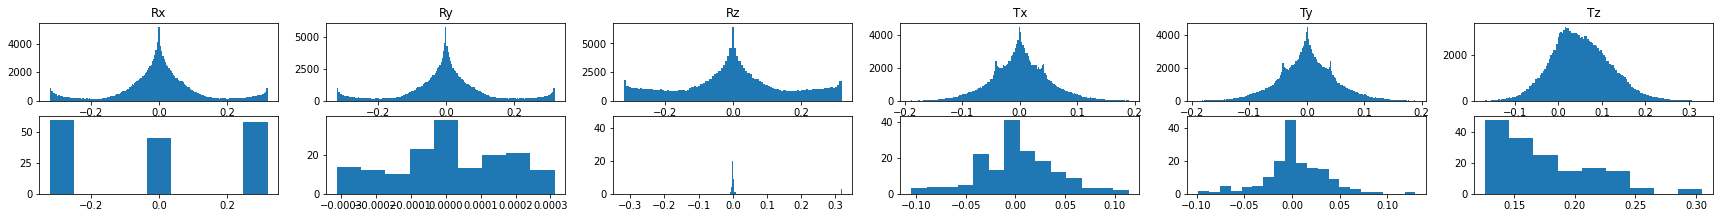

In [8]:
display_trans_prunning(trans_space,ptrans_space)

In [9]:
new_pc_ind=np.vectorize(pyfunc=(lambda x: np.array([x.origin_index,x.image_index])),signature='()->(n)')(ptrans_space)
new_pc_ind=np.unique(new_pc_ind.reshape(1,-1))
signatures=signatures.tolist()
signatures.sort(key=lambda x: getattr(x,"point_index"), reverse=False)
signatures=np.array(signatures)
pruned_signatures=signatures[new_pc_ind]

graficarPropiedad(pruned_signatures,dp,property="sphericity",frac=1)

In [10]:
print("numero de puntos en el espacio de transformadas")
print(len(trans_space))
print("numero de puntos en el espacio filtrado de transformadas")
print(len(ptrans_space))

print('desviacion estandar z='+str(z))
std=np.std(Transformation().v_toPoint(trans_s[:,z]))
print(std)
print(np.std(Transformation().v_toPoint(trans_s[:,z]),axis=0))

numero de puntos en el espacio de transformadas
148520
numero de puntos en el espacio filtrado de transformadas
163
desviacion estandar z=0
0.0955701119055584
[8.11850587e-15 1.18156493e-01 1.18991137e-01 1.56156406e-01
 4.91551576e-02 4.89849945e-02 6.67554786e-02]


In [11]:
Sub_space_2=get_SSpace2(Transformation().v_toPoint(ptrans_space),dp)

In [12]:
Cluster=MeanShift(bandwidth=5,n_jobs=4,cluster_all=False,bin_seeding=True,min_bin_freq=5)
clusters=Cluster.fit_predict(Sub_space_2)
print(np.max(clusters))
np.where(clusters==-1)

2


(array([  9,  10,  41,  42,  45,  46,  51,  61,  67,  77,  84,  99, 100,
        126, 147, 150, 158, 159, 162], dtype=int64),)

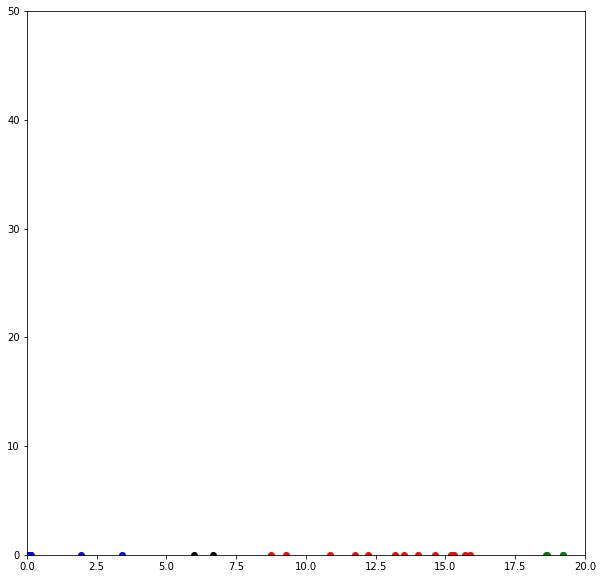

In [13]:
display_cluster(clusters,Sub_space_2)

In [19]:
#RADIO ORIGINAL 0.98 2.61 [mm]

for i in range(np.max(clusters)+1):
    rad=np.mean(Sub_space_2[np.where(clusters==i)][:,0])
    err=np.std(Sub_space_2[np.where(clusters==i)][:,0]-rad)
    print("cluster "+str(i))
    #print(rad/((4/((diagonal_length)**2))))
    print("radio")
    print(str(rad))
    print(str(rad*((4/((diagonal_length)**2))))+" +- "+str(err*((4/((diagonal_length)**2)))))
    #print("error")
    #print(err)

cluster 0
radio
0.13198606700787605
0.0010526012067105872 +- 0.0027488532225710864
cluster 1
radio
21.608367672838458
0.17232874956504715 +- 0.01803914413072253
cluster 2
radio
13.105703180363134
0.104519206422128 +- 0.018281454895350012


In [22]:
trans_cluster=get_cluster_transformation_points(Clusters=clusters,Cluster_id=1,trans_space=ptrans_space)
signature_cluster=get_signatures_from_transformation(signatures,trans_cluster)
cluster_points_index=get_cluster_points_index_from_signatures(signature_cluster)
point_index_cluster=get_cluster_NN_points_index_from_signatures(signature_cluster,dp,pt,20)
pcs=build_pointcloud_simetrie(dp,point_index_cluster)
o3d.visualization.draw_geometries([pcs])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
